# Centernet 
In this notebook, I am going to train a simple centernet based neural network to detect wheat head.
The network architecture and some parts are borrow from [this notebook](https://www.kaggle.com/kmat2019/centernet-keypoint-detector)

**[Inference notebook here](https://www.kaggle.com/nvnnghia/keras-centernet-inference)**

In [23]:

import cv2, os
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np 
from keras.utils import Sequence
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from PIL import Image
from keras.layers import Dense,Dropout, Conv2D,Conv2DTranspose, BatchNormalization, Activation,AveragePooling2D,GlobalAveragePooling2D, Input, Concatenate, MaxPool2D, Add, UpSampling2D, LeakyReLU,ZeroPadding2D
from keras.models import Model
# from keras.objectives import mean_squared_error
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot as plt
import re

# Data preprocessing 
this part is borrowed from this notebook [this notebook](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)

In [27]:
DIR_INPUT = 'global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [32]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [33]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [34]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float32)
train_df['y'] = train_df['y'].astype(np.float32)
train_df['w'] = train_df['w'].astype(np.float32)
train_df['h'] = train_df['h'].astype(np.float32)




In [35]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [36]:
###
category_n=1
output_layer_n=category_n+4


####FOR AUGMENTATION#####
####FOR AUGMENTATION#####
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.AdditiveGaussianNoise(scale=(0, 0.08*255)),
    #sometimes(iaa.Rotate((-90, 90))),
    sometimes(iaa.Fliplr(0.5)),
    #sometimes(iaa.Crop(percent=(0, 0.2))),
    sometimes(iaa.Flipud(0.5))
    
],random_order=False)


/home/skycam/venvs/va/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


# data generator

In [37]:
#####FOR DATASET######
class My_generator(Sequence):
    def __init__(self, dataframe, image_dir, batch_size, input_size=512, is_train = False):
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = self.input_size//4
        self.is_train = is_train
        if self.is_train:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids)/float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_ids[idx*self.batch_size:(idx+1)*self.batch_size]

        if self.is_train:
            return self.train_generator(batch_x)

        return self.valid_generate(batch_x)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_ids= shuffle(self.image_ids)


    def train_generator(self, batch_x):
        batch_imgs = []
        batch_segs = []
        output_height,output_width=self.output_size,self.output_size
        for image_id in batch_x:
            records = self.df[self.df['image_id'] == image_id]

            img = cv2.imread(f'{self.image_dir}/{image_id}.jpg')
            im_h, im_w = img.shape[:2]
            img = cv2.resize(img, (self.input_size, self.input_size))

            boxes = records[['x', 'y', 'w', 'h']].values
            #boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            #boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            # output_height,output_width=104,104

            #PROCESS LABELS
            output_layer=np.zeros((output_height,output_width,(output_layer_n+category_n)))

            for box in boxes:
                x, y, w, h = box
                xc = x + 0.5*w
                yc = y + 0.5*h
                x_c, y_c, width, height = xc*output_height/im_w, yc*output_height/im_h, w*output_height/im_w, h*output_height/im_h
                # print(x_c, y_c)

                category=0 #not classify, just detect
                heatmap=((np.exp(-(((np.arange(output_width)-x_c)/(width/10))**2)/2)).reshape(1,-1)
                                    *(np.exp(-(((np.arange(output_height)-y_c)/(height/10))**2)/2)).reshape(-1,1))
                output_layer[:,:,category]=np.maximum(output_layer[:,:,category],heatmap[:,:])

                output_layer[int(y_c//1),int(x_c//1),category_n+category]=1
                output_layer[int(y_c//1),int(x_c//1),2*category_n]=y_c%1#height offset
                output_layer[int(y_c//1),int(x_c//1),2*category_n+1]=x_c%1
                output_layer[int(y_c//1),int(x_c//1),2*category_n+2]=height/output_height
                output_layer[int(y_c//1),int(x_c//1),2*category_n+3]=width/output_width


            #images_aug, segmaps_aug = seq(images=[img], heatmaps=[output_layer.astype(np.float32)])

            #batch_imgs.append(images_aug[0])
            #batch_segs.append(segmaps_aug[0])
            batch_imgs.append(img)
            batch_segs.append(output_layer)


        batch_imgs = np.array(batch_imgs, np.float32) /255
        batch_segs = np.array(batch_segs, np.float32)

        return batch_imgs, batch_segs


    def valid_generate(self, batch_x, batch_y):
        batch_imgs = []
        batch_segs = []
        output_height,output_width=self.output_size,self.output_size
        for image_id in batch_x:
            records = self.df[self.df['image_id'] == image_id]

            img = cv2.imread(f'{self.image_dir}/{image_id}.jpg')
            im_h, im_w = img.shape[:2]
            img = cv2.resize(img, (self.input_size, self.input_size))

            boxes = records[['x', 'y', 'w', 'h']].values

            #PROCESS LABELS
            output_layer=np.zeros((output_height,output_width,(output_layer_n+category_n)))

            for box in boxes:
                x, y, w, h = box
                xc = x + 0.5*w
                yc = y + 0.5*h
                x_c, y_c, width, height = xc*output_height/im_w, yc*output_height/im_h, w*output_height/im_w, h*output_height/im_h
                # print(x_c, y_c)

                category=0 #not classify, just detect
                heatmap=((np.exp(-(((np.arange(output_width)-x_c)/(width/10))**2)/2)).reshape(1,-1)
                                    *(np.exp(-(((np.arange(output_height)-y_c)/(height/10))**2)/2)).reshape(-1,1))
                output_layer[:,:,category]=np.maximum(output_layer[:,:,category],heatmap[:,:])

                output_layer[int(y_c//1),int(x_c//1),category_n+category]=1
                output_layer[int(y_c//1),int(x_c//1),2*category_n]=y_c%1#height offset
                output_layer[int(y_c//1),int(x_c//1),2*category_n+1]=x_c%1
                output_layer[int(y_c//1),int(x_c//1),2*category_n+2]=height/output_height
                output_layer[int(y_c//1),int(x_c//1),2*category_n+3]=width/output_width

            #images_aug, segmaps_aug = seq(images=[img], heatmaps=[output_layer.astype(np.float32)])


            batch_imgs.append(img)
            batch_segs.append(output_layer)


        batch_imgs = np.array(batch_imgs, np.float32) /255
        batch_segs = np.array(batch_segs, np.float32)

        return batch_imgs, batch_segs

# Test generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


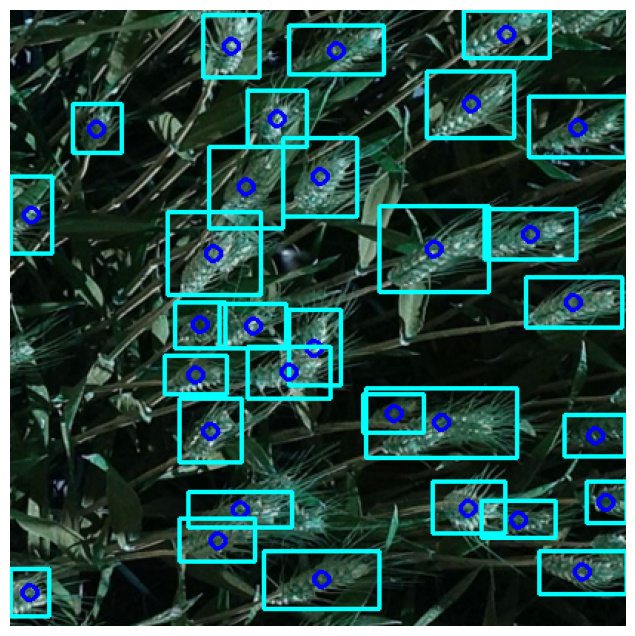

In [38]:
def test_dataset():
    
    mygen = My_generator(train_df, DIR_TRAIN, batch_size=1, is_train=True, input_size = 416)

    for count, (x,y) in enumerate(mygen):
        # print(x.shape)
        # print(y.shape)
        x = x[0]
        y= y[0]

        points = np.argwhere(y[:,:,1] ==1)
        for y1,x1 in points:
            # print(x1,y1)
            offsety = y[:,:,2][y1,x1]
            offetx = y[:,:,3][y1,x1]
            
            h = y[:,:,4][y1,x1]*104
            w = y[:,:,5][y1,x1]*104

            x1, y1 = x1 + offetx, y1+offsety 

            xmin = int((x1-w/2)*4)
            xmax = int((x1+w/2)*4)
            ymin = int((y1-h/2)*4)
            ymax = int((y1+h/2)*4)

            cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (0,255,255), 2)


            cv2.circle(x, (int(x1*4),int(y1*4)), 5, (0,0,255), 2) 

        #cv2.imshow('djpg',y[:,:,1]*255)
        #cv2.imshow('drawjpg',x)
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        ax.set_axis_off()
        ax.imshow(x)
        break
        
test_dataset()

# LOSSES FUNCTION#####

In [39]:

def all_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    alpha=2.
    beta=4.

    heatmap_true_rate = K.flatten(y_true[...,:category_n])
    heatmap_true = K.flatten(y_true[...,category_n:(2*category_n)])
    heatmap_pred = K.flatten(y_pred[...,:category_n])
    heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    offsetloss=K.sum(K.abs(y_true[...,2*category_n]-y_pred[...,category_n]*mask)+K.abs(y_true[...,2*category_n+1]-y_pred[...,category_n+1]*mask))
    sizeloss=K.sum(K.abs(y_true[...,2*category_n+2]-y_pred[...,category_n+2]*mask)+K.abs(y_true[...,2*category_n+3]-y_pred[...,category_n+3]*mask))
    
    all_loss=(heatloss+1.0*offsetloss+5.0*sizeloss)/N
    return all_loss

def size_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    sizeloss=K.sum(K.abs(y_true[...,2*category_n+2]-y_pred[...,category_n+2]*mask)+K.abs(y_true[...,2*category_n+3]-y_pred[...,category_n+3]*mask))
    return (5*sizeloss)/N

def offset_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    offsetloss=K.sum(K.abs(y_true[...,2*category_n]-y_pred[...,category_n]*mask)+K.abs(y_true[...,2*category_n+1]-y_pred[...,category_n+1]*mask))
    return (offsetloss)/N
  
def heatmap_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    alpha=2.
    beta=4.

    heatmap_true_rate = K.flatten(y_true[...,:category_n])
    heatmap_true = K.flatten(y_true[...,category_n:(2*category_n)])
    heatmap_pred = K.flatten(y_pred[...,:category_n])
    heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    return heatloss/N

# Model definition

In [40]:
##########MODEL#############

def aggregation_block(x_shallow, x_deep, deep_ch, out_ch):
    x_deep= Conv2DTranspose(deep_ch, kernel_size=2, strides=2, padding='same', use_bias=False)(x_deep)
    x_deep = BatchNormalization()(x_deep)   
    x_deep = LeakyReLU(alpha=0.1)(x_deep)
    x = Concatenate()([x_shallow, x_deep])
    x=Conv2D(out_ch, kernel_size=1, strides=1, padding="same")(x)
    x = BatchNormalization()(x)   
    x = LeakyReLU(alpha=0.1)(x)
    return x
  


def cbr(x, out_layer, kernel, stride):
    x=Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def resblock(x_in,layer_n):
    x=cbr(x_in,layer_n,3,1)
    x=cbr(x,layer_n,3,1)
    x=Add()([x,x_in])
    return x  


#I use the same network at CenterNet
def create_model(input_shape, aggregation=True):
    input_layer = Input(input_shape)
    
    #resized input
    input_layer_1=AveragePooling2D(2)(input_layer)
    input_layer_2=AveragePooling2D(2)(input_layer_1)

    #### ENCODER ####

    x_0= cbr(input_layer, 16, 3, 2)#512->256
    concat_1 = Concatenate()([x_0, input_layer_1])

    x_1= cbr(concat_1, 32, 3, 2)#256->128
    concat_2 = Concatenate()([x_1, input_layer_2])

    x_2= cbr(concat_2, 64, 3, 2)#128->64
    
    x=cbr(x_2,64,3,1)
    x=resblock(x,64)
    x=resblock(x,64)
    
    x_3= cbr(x, 128, 3, 2)#64->32
    x= cbr(x_3, 128, 3, 1)
    x=resblock(x,128)
    x=resblock(x,128)
    x=resblock(x,128)
    
    x_4= cbr(x, 256, 3, 2)#32->16
    x= cbr(x_4, 256, 3, 1)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
 
    x_5= cbr(x, 512, 3, 2)#16->8
    x= cbr(x_5, 512, 3, 1)
    
    x=resblock(x,512)
    x=resblock(x,512)
    x=resblock(x,512)
    
    #### DECODER ####
    x_1= cbr(x_1, output_layer_n, 1, 1)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
    x_2= cbr(x_2, output_layer_n, 1, 1)
    x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
    x_3= cbr(x_3, output_layer_n, 1, 1)
    x_3 = aggregation_block(x_3, x_4, output_layer_n, output_layer_n) 
    x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)

    x_4= cbr(x_4, output_layer_n, 1, 1)

    x=cbr(x, output_layer_n, 1, 1)
    x= UpSampling2D(size=(2, 2))(x)#8->16 

    x = Concatenate()([x, x_4])
    x=cbr(x, output_layer_n, 3, 1)
    x= UpSampling2D(size=(2, 2))(x)#16->32

    x = Concatenate()([x, x_3])
    x=cbr(x, output_layer_n, 3, 1)
    x= UpSampling2D(size=(2, 2))(x)#32->64 

    x = Concatenate()([x, x_2])
    x=cbr(x, output_layer_n, 3, 1)
    x= UpSampling2D(size=(2, 2))(x)#64->128 

    x = Concatenate()([x, x_1])
    x=Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
    out = Activation("sigmoid")(x)
    
    model=Model(input_layer, out)
    
    return model

# Training

In [56]:
def lrs(epoch):
    lr = 0.001
    if epoch >= 20: lr = 0.0002
    return lr

In [54]:
    
batch_size=128
input_size=256
n_epoch=30

learning_rate=0.001

mygen = My_generator(train_df, DIR_TRAIN, batch_size=batch_size, is_train=True, input_size = input_size)
myval = My_generator(valid_df, DIR_TRAIN, batch_size=batch_size, is_train=True, input_size = input_size)


model=create_model(input_shape=(input_size,input_size,3))

if os.path.isfile('final_weights.h5'):
    model.load_weights('final_weights.h5')

lr_schedule = LearningRateScheduler(lrs)


# EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 60, verbose = 1)
# ModelCheckpoint
#weights_dir = './'

#if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
#model_checkpoint = ModelCheckpoint(weights_dir + "{epoch:02d}-{val_loss:.3f}.hdf5", monitor = 'val_loss', verbose = 1,
#                                      save_best_only = False, save_weights_only = True, period = 3)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 4, verbose = 1)


#     print(model.summary())

model.compile(loss=all_loss, optimizer=Adam(lr=learning_rate), metrics=[heatmap_loss,size_loss,offset_loss])

hist = model.fit(
    mygen,
    steps_per_epoch = len(train_df['image_id'].unique()) // batch_size,
    epochs = n_epoch,
    validation_data=myval,
    validation_steps = len(valid_df['image_id'].unique()) // batch_size,
    callbacks = [early_stopping, reduce_lr],
    shuffle = True,
    verbose = 1
)
model.save_weights('final_weights.h5')

#print(hist.history.keys())
#np.save('his.npy', hist.history)

In [55]:
train(n_epoch=1)

/home/skycam/venvs/va/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


21/21 [==============================] - 84s 4s/step - loss: 2.3681 - heatmap_loss: 1.4421 - size_loss: 0.4303 - offset_loss: 0.4896 - val_loss: 364.9676 - val_heatmap_loss: 362.9816 - val_size_loss: 1.0409 - val_offset_loss: 0.9451 - lr: 0.0010
